In [45]:
"""
Copyright (C) 2017 Free Software Foundation

This file is part of GNU Radio

GNU Radio is free software; you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation; either version 3, or (at your option)
any later version.

GNU Radio is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with GNU Radio; see the file COPYING.  If not, write to
the Free Software Foundation, Inc., 51 Franklin Street,
Boston, MA 02110-1301, USA.

GNU Octave script to accompany the GNURadio flowgraph:

    gnuradio/gr-digital/examples/demod/symbol_sync_test_float.grc

to simulate the Mueller and Muller and Gardner timing error detectors
and compute Expected TED gains applicable to the situation in that
flowgraph.
"""

'\nCopyright (C) 2017 Free Software Foundation\n\nThis file is part of GNU Radio\n\nGNU Radio is free software; you can redistribute it and/or modify\nit under the terms of the GNU General Public License as published by\nthe Free Software Foundation; either version 3, or (at your option)\nany later version.\n\nGNU Radio is distributed in the hope that it will be useful,\nbut WITHOUT ANY WARRANTY; without even the implied warranty of\nMERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the\nGNU General Public License for more details.\n\nYou should have received a copy of the GNU General Public License\nalong with GNU Radio; see the file COPYING.  If not, write to\nthe Free Software Foundation, Inc., 51 Franklin Street,\nBoston, MA 02110-1301, USA.\n\nGNU Octave script to accompany the GNURadio flowgraph:\n\n    gnuradio/gr-digital/examples/demod/symbol_sync_test_float.grc\n\nto simulate the Mueller and Muller and Gardner timing error detectors\nand compute Expected TED gains appl

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [47]:
def rrc_filter(N, beta):
# Impulse response of the root rise cosine filter given the number of samples
# Inputs:
# beta: roll-off factor
# p: time samples of the filter
# num_samples: number of samples, must be a even number
# T_samples: number of samples per signal period
    
    Ts = 1
    t = (1/Ts)*np.linspace(-Ts/np.sqrt(1+beta/2), Ts/np.sqrt(1+beta/2), N)
    p = np.zeros(len(t));
    for i in np.arange(len(t)):
        p[i] = (4*beta/(np.pi*np.sqrt(Ts)))*(np.cos((1+beta)*np.pi*t[i]/Ts) +
                np.sin((1-beta)*np.pi*t[i]/Ts)/(4*beta*t[i]/Ts))/(1-(4*beta*t[i]/Ts)**2)
        
    t_0 = 0
    t_0 = [i for i in range(len(t)) if t[i] == 0.0] 
    if (t_0 != 0):
        p[t_0] = (4*beta/(np.pi*np.sqrt(Ts)))*(1 + (1-beta)*np.pi/(4*beta))

    t_1 = Ts/(4*beta)
    t_1p = 0
    t_1m = 0
    t_1p =  [i for i in range(len(t)) if t[i] == t_1]
    t_1m = [i for i in range(len(t)) if t[i] == -t_1]
    if (t_1p != 0):
        p[t_1p] = (beta/np.sqrt(2*Ts))*((1+2/np.pi)*np.sin(np.pi/(4*beta)) +
                                        (1-2/np.pi)*np.cos(np.pi/(4*beta)))
        p[t_1m] = (beta/np.sqrt(2*Ts))*((1+2/np.pi)*np.sin(np.pi/(4*beta)) +
                                        (1-2/np.pi)*np.cos(np.pi/(4*beta)))
      
    p = p - np.amin(p)
    # Guarantizes normalized energy
    p = p/np.sum(p)

    return np.resize(p, (100,1))

In [48]:
# Define some constants
# Number of bits used for timing error analysis
N_bits = 30000              
Rb = 1200
bits_per_sym = 1
baud_rate = Rb/bits_per_sym
# Number of symbols used for timing error analysis
N_syms = N_bits/bits_per_sym 
# samples/symbol used for timing error analysis
tea_sps = 100
# sample rate used for timing error analysis             
tea_Fs = tea_sps * baud_rate
# actual samples per symbol used in application
a_sps = 6.66667
# actual sample rate used in application           
a_Fs = a_sps * baud_rate
# Roll-off factor for the root-raised-cosine prototype filter
beta = 0.35

In [49]:
# Select which one prototype filter to calculate TED, 0 = rectangular, whatever = root-raised-cosine
selection = 1

In [50]:
# Create prototype filter impulse response, must be rectangular or root-raised-cosine

if selection == 0:
    pf_taps = 1/tea_sps * np.ones((tea_sps, 1))
else:
    pf_taps = rrc_filter(tea_sps, beta)
    
pf_len = len(pf_taps)
pf_delay = pf_len/2

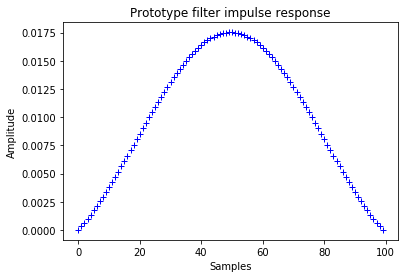

In [51]:
# Show impulse response of the prototype filter
plt.figure(1)
plt.plot(pf_taps, 'b+')
plt.title('Prototype filter impulse response')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

In [52]:
# Generate some bits
bits = np.random.randint(0, 2, N_bits)
# Convert the bits to NRZ symbols in [-1, 1]
symbols = 2*bits-1;

In [53]:
# Convert symbols to baseband pulses
h = np.zeros((tea_sps, 1))
h[2] = 1
x = tea_sps * sig.upfirdn(h[:,0], symbols, tea_sps, 1)
baseband = sig.convolve(pf_taps[:, 0], x)

In [54]:
# Create rectangular matched filter, that's a little too long (7 sps vs
# 6.667 sps) to introduce more ISI
# Play with isi samples to see S-curve effects

isi_sps = round((tea_sps/a_sps * 7) - tea_sps)

if (np.mod(isi_sps, 2) != 0):
    isi_sps = isi_sps + 1
    
if selection == 0:
    mf_taps = 1/(tea_sps+isi_sps) * np.ones((tea_sps+isi_sps, 1))
else:
    mf_taps = rrc_filter(tea_sps+isi_sps, beta)
    
mf_len = len(mf_taps)
mf_delay = mf_len/2

In [55]:
# Matched filter the received baseband pulses
mf_baseband = sig.convolve(mf_taps[:, 0], baseband)
# Play with amplitude to see S-curve effects
mf_baseband = mf_baseband * 1.0

In [56]:
# Symbol centers are now at indices n*tea_sps + isi_sps/2 (I think!)
# Symbol clock period is tea_sps samples
# Symbol peaks are perfectly at +/-1.0

# Timing offset granularity is in 1/tea_sps-th of a symbol
tau = np.arange(-tea_sps/2, tea_sps/2 - 1, 1)
tau_norm = tau/tea_sps*a_sps

In [57]:
# M&M TED. Constellation points at -1.0 and +1.0.
# Gardener TED.
# Perfect estimate of symbol clock period.
# No external noise.
mm_ted_output = np.zeros((int(N_syms-2), len(tau)))
ga_ted_output = np.zeros((int(N_syms-2), len(tau)))
# For each known symbol peak set (M&M needs prev and current symbol)
for i in np.arange(N_syms - 3).astype(int):
    # Cycle through all the timing offsets around this symbol
    # using a perfect symbol clock period estimate
    opt_prev_idx = int((i-1)*tea_sps + isi_sps/2)
    opt_curr_idx = int(i*tea_sps + isi_sps/2)
    for j in np.arange(len(tau)).astype(int):
        prev_soft_sym = mf_baseband[opt_prev_idx - int(tau[j])]
        mid_soft_samp = mf_baseband[int((opt_curr_idx + opt_prev_idx)/2 - tau[j])]
        curr_soft_sym = mf_baseband[opt_curr_idx - int(tau[j])]
        
        if (prev_soft_sym >= 0):
            prev_decision = 1
        else:
            prev_decision = -1

        if (curr_soft_sym >= 0):
            curr_decision = 1
        else:
            curr_decision = -1

        mm_ted_output[i,j] = prev_decision * curr_soft_sym - curr_decision * prev_soft_sym
        ga_ted_output[i,j] = (prev_soft_sym - curr_soft_sym) * mid_soft_samp

mean_mm_ted_output = np.mean(mm_ted_output, 0)
mean_ga_ted_output = np.mean(ga_ted_output, 0)

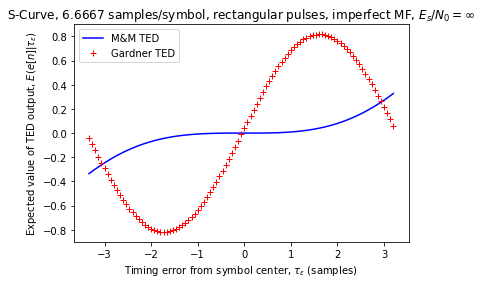

In [58]:
# Plot the S-Curves
plt.figure(2)
plt.plot(tau_norm, mean_mm_ted_output, 'b-', tau_norm, mean_ga_ted_output, 'r+')
plt.title(r'S-Curve, 6.6667 samples/symbol, rectangular pulses, imperfect MF, $E_s/N_0 = \infty$')
plt.xlabel(r'Timing error from symbol center, $\tau_\epsilon$ (samples)')
plt.ylabel(r'Expected value of TED output, $E(e[n] | \tau_\epsilon)$')
plt.legend(('M&M TED', 'Gardner TED'))
plt.show()

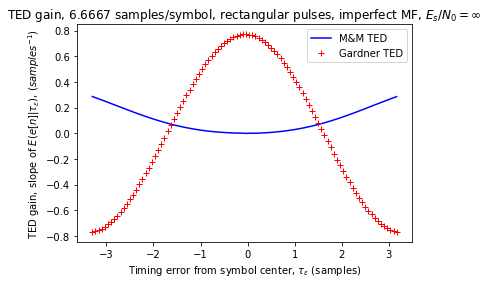

In [59]:
# Plot the TED gains
plt.figure(3)
tau_diff = tau[0 : -1] + 0.5 # 
tau_diff_norm = tau_diff/tea_sps*a_sps
diff_mm_ted_output = np.diff(mean_mm_ted_output)/(a_sps/tea_sps)
diff_ga_ted_output = np.diff(mean_ga_ted_output)/(a_sps/tea_sps)
plt.plot(tau_diff_norm, diff_mm_ted_output , 'b-', tau_diff_norm, diff_ga_ted_output , 'r+')
plt.title(r'TED gain, 6.6667 samples/symbol, rectangular pulses, imperfect MF, $E_s/N_0 = \infty$')
plt.xlabel(r'Timing error from symbol center, $\tau_\epsilon$ (samples)')
plt.ylabel(r'TED gain, slope of $E(e[n] | \tau_\epsilon)$, ($samples^{-1}$)')
plt.legend(('M&M TED', 'Gardner TED'))
plt.show()

In [60]:
# Print out the central TED gains
k = len(diff_mm_ted_output)
mm_ted_gain = np.mean(diff_mm_ted_output[int((k-1)/2):int((k-1)/2+1)])
print('M&M TED gain = ', mm_ted_gain)
k = len(diff_ga_ted_output)
ga_ted_gain = np.mean(diff_ga_ted_output[int((k-1)/2):int((k-1)/2+1)])
print('Gardner TED gain = ', ga_ted_gain)

M&M TED gain =  0.0004096506301699937
Gardner TED gain =  0.7714314820067096
